In [3]:
import wandb
import pandas as pd
import pickle
import seaborn as sns 
import functools
import operator 

In [4]:
def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

id_df = read_wandb_csv("data/A_4_dataset_choice_test.csv")
id_df

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,ID,Group,...,test_f1_best_eval_loss,test_f1_best_f1,train_loss,train_p_max,train_p_var,train_st1_loss,train_st1_p_max,train_st2_loss,train_st2_p_max,vector_norms
0,27_S5_ID_14_VAN,killed,-,ricu,"SWP5, vanilla",2024-01-14T10:19:14.000Z,203,NaN,ab44uapw,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100195,0.905648,NaN
1,27_S5_ID_13_VAN,finished,-,ricu,"SWP5, vanilla",2024-01-14T10:11:31.000Z,438,NaN,hrvhvkw7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010143,0.989919,NaN
2,27_S5_ID_12_VAN,finished,-,ricu,"SWP5, vanilla",2024-01-14T10:03:58.000Z,428,NaN,o21sms9h,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012322,0.987801,NaN
3,27_S5_ID_11_VAN,finished,-,ricu,"SWP5, vanilla",2024-01-14T09:45:41.000Z,1073,NaN,ozlvjk8w,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001846,0.998156,NaN
4,27_S5_ID_10_VAN,finished,-,ricu,"SWP5, vanilla",2024-01-14T09:38:54.000Z,384,NaN,tj7hs264,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009770,0.990293,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,27_S0_ID_04_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:18:21.000Z,237,NaN,5y4ufaf2,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000630,0.999371,0.001358,0.998647,"{""_type"":""histogram"",""bins"":[0.000002224890522..."
101,27_S0_ID_03_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:10:26.000Z,451,NaN,nhuruz8h,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000363,0.999637,0.008447,0.999218,"{""_type"":""histogram"",""bins"":[0.000002546078121..."
102,27_S0_ID_02_MOD,finished,-,ricu,"SWP0, modded",2024-01-14T00:04:48.000Z,313,NaN,emk1mo4s,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000278,0.999722,0.000514,0.999486,"{""_type"":""histogram"",""bins"":[2.043253601868855..."
103,27_S0_ID_01_MOD,finished,-,ricu,"SWP0, modded",2024-01-13T23:59:52.000Z,273,NaN,kc8vz17i,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000496,0.999504,0.002935,0.998186,"{""_type"":""histogram"",""bins"":[1.524182522416595..."


In [5]:
from tqdm import tqdm
run_ids = id_df["ID"]

api = wandb.Api()

all_dfs = []
metrics_train = ["train_st2_loss"]
metrics_eval = ["accuracy","eval_loss","eval_p_max"]
metrics_lr = ["learning_rate"]
index_keys = ["_step","epoch"]

# Add tqdm to the loop for progress bar
for run_id in tqdm(run_ids):
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the history
    history_train = run.scan_history(keys=metrics_train+index_keys)
    df_run =  pd.DataFrame([row for row in history_train])
    
    history_eval = run.scan_history(keys=metrics_eval+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_eval]), on=['_step', 'epoch'], how='outer')
    
    history_lr = run.scan_history(keys=metrics_lr+index_keys)
    df_run = df_run.merge(pd.DataFrame([row for row in history_lr]), on=['_step', 'epoch'], how='outer')
    df_run = df_run.sort_values(by="_step", ascending=True,ignore_index=True)
    # last_step_diff = df_run["_step"].iloc[-1] - df_run["_step"].iloc[-2]
    # first_step_diff = df_run["_step"].iloc[1] - df_run["_step"].iloc[0]
    # if last_step_diff != first_step_diff:
    #     df_run.at[df_run.index[-1], 'train_st2_loss'] = df_run['train_st2_loss'].iloc[-1] / last_step_diff
    df_run["learning_rate"] = df_run["learning_rate"].fillna(0)

    for key, value in run.config.items():
        df_run = df_run.assign(**{key: value})
    
    all_dfs.append(df_run)

df = pd.concat(all_dfs,axis=0,ignore_index=True)
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
with open("data/A_4_dataset.pkl",'wb') as f:
    pickle.dump(df,f)

  0%|          | 0/105 [00:00<?, ?it/s]

100%|██████████| 105/105 [04:19<00:00,  2.47s/it]


In [8]:
with open("data/A_4_dataset.pkl",'rb') as f:
    df = pickle.load(f)
df.head()

,train_st2_loss,_step,epoch,accuracy,eval_loss,eval_p_max,learning_rate,seed,beta1,beta2,...,num_warmup_steps,lr_scheduler_type,pad_to_max_length,model_name_or_path,warmup_steps_fraction,early_stopping_patience,ignore_mismatched_sizes,early_stopping_min_delta,per_device_eval_batch_size,per_device_train_batch_size
0,NaN,0,-1,0.453613,0.806656,0.662279,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
1,0.821650,4,1,0.454590,0.804965,0.660702,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
2,0.780583,8,3,0.454590,0.798809,0.654897,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
3,0.775312,12,5,0.458496,0.788556,0.644111,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32
4,0.752005,16,7,0.459473,0.774892,0.627778,0.00003,3,0.9,0.999,...,80,linear,False,bert-base-uncased,0.1,40,False,0,128,32


qnli 1e-05
                                   mean    median       std
task_name learning_rate _step                              
qnli      0.00001       800    0.724772  0.727051  0.010922
                        784    0.725098  0.727051  0.010392
                        768    0.723511  0.723145  0.008783
                        752    0.723633  0.723389  0.009187
                        736    0.723633  0.723389  0.009187
                        720    0.727051  0.729004  0.011199
                        704    0.727539  0.729004  0.010847
                        688    0.727441  0.729004  0.010937
                        672    0.727539  0.729980  0.010836
                        656    0.727930  0.731445  0.011541
                        640    0.727344  0.730469  0.011506
                        624    0.727637  0.729980  0.011195
                        608    0.727441  0.729980  0.011163
                        592    0.726953  0.729004  0.011110
                        576  

KeyError: 'Level insert_dropout not found'

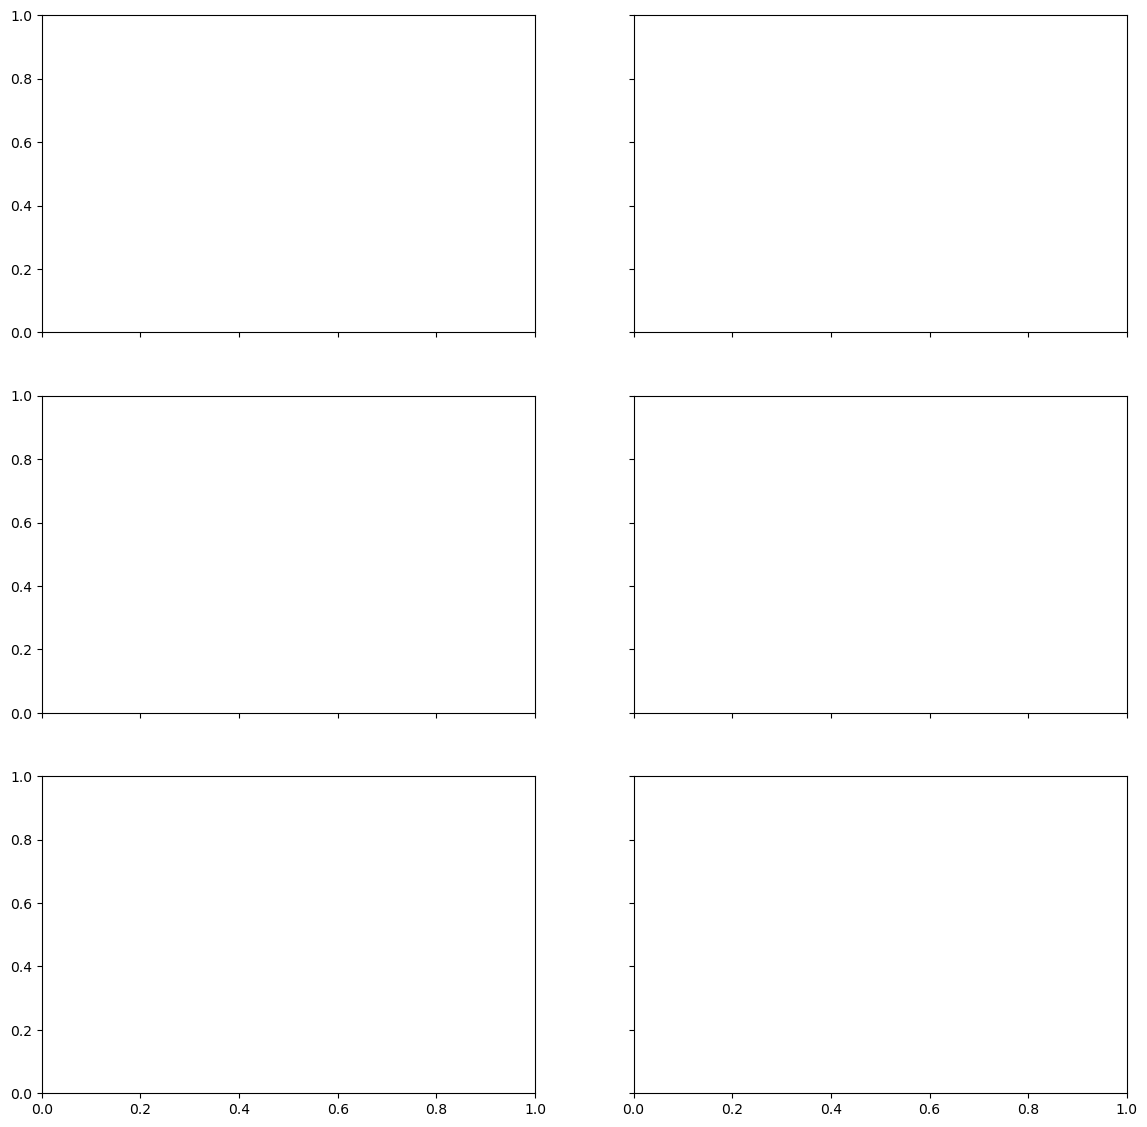

In [7]:
import matplotlib.pyplot as plt
selected_rows = functools.reduce(
    operator.and_,
    [
        df["training_size"] == 256
        # df["Tags"].str.contains('modded')
    ]  
    )
filtered_df = df.loc[selected_rows]

subplot_columns = sorted(df["mode"].unique())
subplot_rows = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    len(subplot_rows),
    len(subplot_columns),
    sharex=True,
    sharey='row',
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idy, col_val in enumerate(subplot_columns):
    for idx, row_val in enumerate(subplot_rows):
        grouped_df = filtered_df.loc[df["mode"]==col_val].groupby(["task_name","learning_rate","_step"])
        statistics = grouped_df[row_val].agg(['mean', 'median', 'std'])
        statistics = statistics.sort_index(level=["task_name","learning_rate"], ascending=False)

        for (task_name, learning_rate), group in statistics.groupby(level=['task_name', 'learning_rate']):
            axs[idx,idy].plot(
                group.index.get_level_values('_step'),
                group["median"],
                label=f'Dataset: {task_name}, Learning Rate: {learning_rate}'
                )

        if idy == 0:
            axs[idx,idy].set_ylabel(row_val)
        if idx == 0:
            axs[idx,idy].set_title(f'Mode: {col_val}')
        if idx == len(subplot_columns) - 1:
            axs[idx,idy].set_xlabel('Step')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idx == 0:
            axs[idx,idy].legend()


fig.suptitle('Influence of the Dropout Rate (Training Set Size: 256)', fontsize=16,weight='bold')
# Show the plot
plt.tight_layout()
plt.savefig('img/A_3_dropout.pdf', format='pdf')
plt.show()